In [7]:
import backtrader as bt
import yfinance as yf
from datetime import datetime

symbols = ['AAPL', 'GOOGL', 'GLD']
data_feeds = []

for symbol in symbols:
    data = yf.download(symbol, start="2024-01-01", end="2025-02-18", auto_adjust=False)
    data.columns = [col[0] for col in data.columns]
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    data_feed = bt.feeds.PandasData(dataname=data)
    data_feeds.append(data_feed)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
class MultiAssetStrategy(bt.Strategy):
    def __init__(self):
        self.size = 0  

    def next(self):
        if self.size == 0:
            cash = self.broker.getcash()
            per_asset_cash = cash / len(self.datas)  

            for data in self.datas:
                size = int(per_asset_cash / data.close[0]) 
                self.buy(data=data, size=size)
                self.size += size  

In [10]:
cerebro = bt.Cerebro()
cerebro.addstrategy(MultiAssetStrategy)

for data_feed in data_feeds:
    cerebro.adddata(data_feed)

cerebro.broker.setcash(50000.0)
# Execute backtest
print(f'Initial capital: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final capital: {cerebro.broker.getvalue():.2f}')
cerebro.plot(iplot=False)


Initial capital: 50000.00
Final capital: 67875.66


[[<Figure size 640x480 with 8 Axes>]]

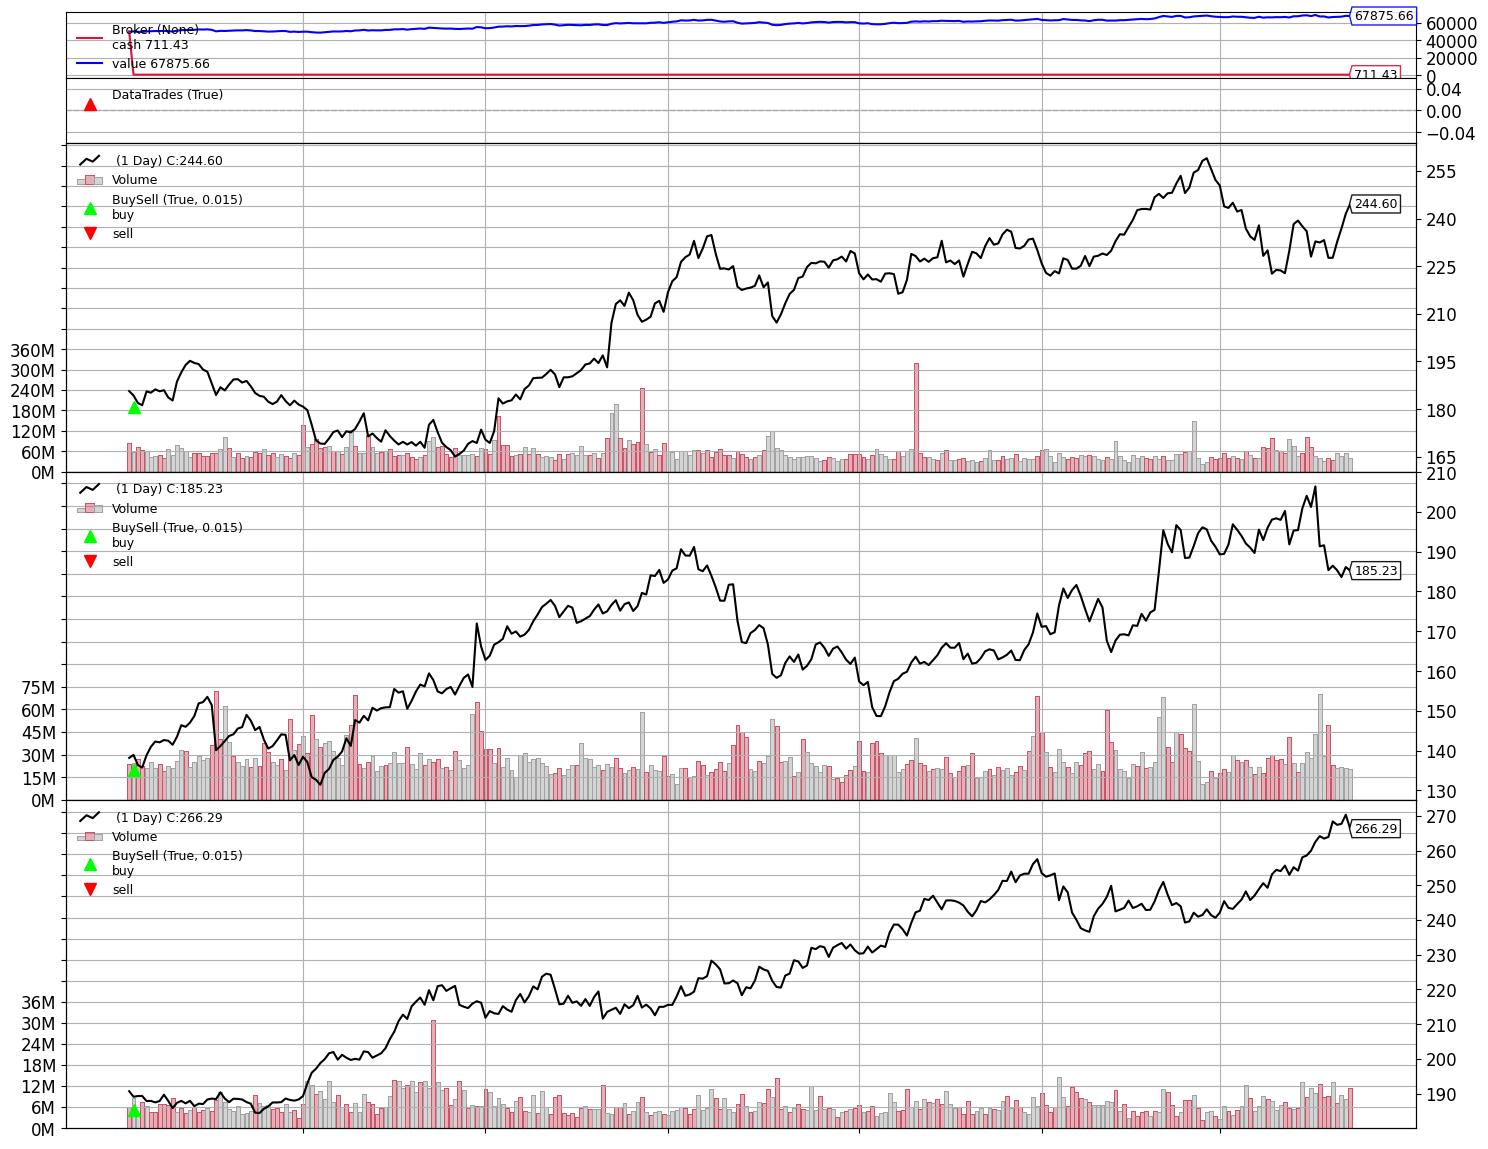

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12})
img = cerebro.plot(iplot = False)

# Comparison with Single Asset

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


single_asset_volatilities {'AAPL': 0.23169128043312587, 'GOOGL': 0.28584095868942905, 'GLD': 0.1467314610997816}


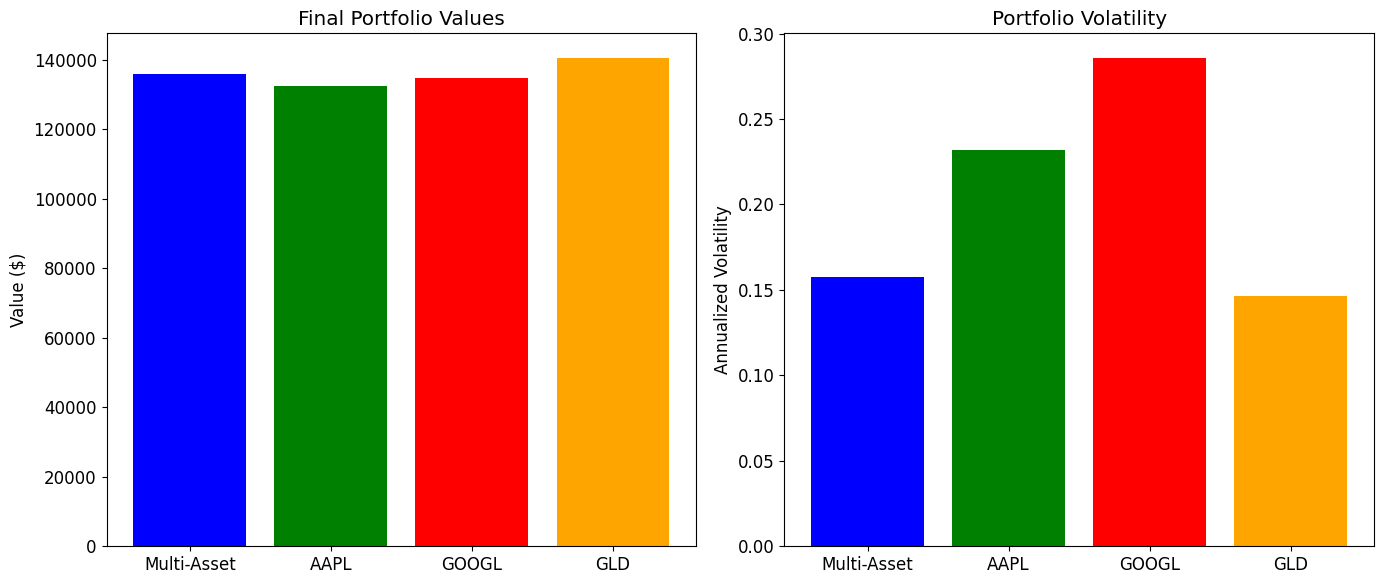

In [12]:
import backtrader as bt
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

symbols = ['AAPL', 'GOOGL', 'GLD']
data_feeds = {}

for symbol in symbols:
    data = yf.download(symbol, start="2024-01-01", end="2025-02-18", auto_adjust=False)
    data.columns = [col[0] for col in data.columns]
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    data_feeds[symbol] = bt.feeds.PandasData(dataname=data)

# Create a multi-asset portfolio strategy
class MultiAssetStrategy(bt.Strategy):
    def __init__(self):
        self.size = 0  # Used to save the position size of each asset
        self.daily_value = []  # Used to record the daily portfolio value

    def next(self):
        # On the first run, allocate funds based on existing cash
        if self.size == 0:
            cash = self.broker.getcash()
            per_asset_cash = cash / len(self.datas)  # Evenly distribute funds for each asset

            for data in self.datas:
                size = int(per_asset_cash / data.close[0])  # Calculate the number of shares to buy based on the price of each asset
                self.buy(data=data, size=size)
                self.size += size  # Update the position size

        self.daily_value.append(self.broker.getvalue())  # Record the daily portfolio value

# Create a single-asset investment strategy
class SingleAssetStrategy(bt.Strategy):
    def __init__(self):
        self.size = 0  # Used to save the position size
        self.daily_value = []  # Used to record the daily portfolio value

    def next(self):
        if self.size == 0:
            cash = self.broker.getcash()
            size = int(cash / self.datas[0].close[0])
            self.buy(data=self.datas[0], size=size)
            self.size += size

        self.daily_value.append(self.broker.getvalue())  # Record the daily portfolio value

# Initialize the Cerebro backtesting engine
def run_strategy(strategy_class, data_feed):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy_class)
    cerebro.adddata(data_feed)
    cerebro.broker.setcash(100000.0)
    result = cerebro.run()
    return result[0].daily_value  # Return the daily portfolio value

# Run the backtest for the multi-asset strategy and record the daily asset values
multi_asset_values = run_strategy(MultiAssetStrategy, data_feeds['AAPL'])
for symbol in ['GOOGL', 'GLD']:
    cerebro = bt.Cerebro()
    cerebro.adddata(data_feeds[symbol])
    cerebro.addstrategy(MultiAssetStrategy)
    cerebro.broker.setcash(100000.0)
    result = cerebro.run()
    multi_asset_values = [x + y for x, y in zip(multi_asset_values, result[0].daily_value)]

multi_asset_values = [x / 3 for x in multi_asset_values]  # Calculate the daily average value for the multi-asset portfolio

# Run the backtest for each single-asset strategy
single_asset_values = {}
for symbol in symbols:
    single_asset_values[symbol] = run_strategy(SingleAssetStrategy, data_feeds[symbol])

# Calculate volatility
def calculate_volatility(daily_values):
    returns = pd.Series(daily_values).pct_change().dropna()
    volatility = returns.std() * np.sqrt(252)  # Annualized volatility
    return volatility

multi_asset_volatility = calculate_volatility(multi_asset_values)
single_asset_volatilities = {symbol: calculate_volatility(values) for symbol, values in single_asset_values.items()}
print("single_asset_volatilities", single_asset_volatilities)

# Visualize the results
plt.figure(figsize=(14, 6))

# Compare the final portfolio values
final_values = [multi_asset_values[-1]] + [single_asset_values[symbol][-1] for symbol in symbols]
plt.subplot(1, 2, 1)
plt.bar(['Multi-Asset'] + symbols, final_values, color=['blue', 'green', 'red', 'orange'])
plt.title('Final Portfolio Values')
plt.ylabel('Value ($)')

# Compare the volatilities
volatilities = [multi_asset_volatility] + [single_asset_volatilities[symbol] for symbol in symbols]
plt.subplot(1, 2, 2)
plt.bar(['Multi-Asset'] + symbols, volatilities, color=['blue', 'green', 'red', 'orange'])
plt.title('Portfolio Volatility')
plt.ylabel('Annualized Volatility')

plt.tight_layout()
plt.show()